In [1]:
## data
import pandas as pd
import numpy as np
import datetime as dt
from dateutil.relativedelta import relativedelta
from unicodedata import normalize

## vis
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
# contagem de aging
from collections import Counter

from IPython.display import display, HTML

## modelo
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
from sklearn.metrics import average_precision_score, mean_absolute_error, roc_curve, auc, roc_auc_score
from scikitplot.metrics import plot_roc
from sklearn.model_selection import cross_val_score

# check xgboost version
from xgboost import XGBClassifier, XGBRegressor

import dill as pickle

## alertas
import warnings
warnings.filterwarnings("ignore")

In [2]:
# %pip install xgboost==1.5.0

***
### Funções

In [3]:
def aucur(y_test, preds):
    # calculate AUC
    aucur = roc_auc_score(y_test, preds)
    print('AUC: %.3f' % aucur)

    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(y_test, preds)

    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    # show the plot
    plt.show()

In [4]:
def just_check_nan(df):
    # Check NaN Pandas and Numpy
    missing_val_count_by_column = (df.isna().sum())

    columns_with_nan = missing_val_count_by_column[missing_val_count_by_column > 0]
    print('Dados com NaN:')
    print(columns_with_nan)
    print('')
    print('columns_with_nan.shape', columns_with_nan.shape)
    print('')

In [5]:
def plot_feature_freq(df, feature):
    labels, counts = np.unique(df[feature].dropna(), return_counts=True)
    total = counts[0] + counts[1]
    plt.figure(figsize=(10, 7))
    ax = sns.barplot(x=labels, y=(counts/total)*100, data = df)
    ax2 = sns.barplot(x=labels, y=counts, data = df)

    for p in ax.patches:
        ax.annotate('{:.2f}%'.format(p.get_height()), (p.get_x() + 0.3, p.get_height()+0.6), rotation = 0)

#     ax.set(xlabel='Trocou', ylabel='Porcentagem')
    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    plt.show()

In [6]:
def plot_feature_freq_mes(df, feature):
    labels, counts = np.unique(df[feature].dropna(), return_counts=True)
    total = counts[0] + counts[1] + counts[2] + counts[3] + counts[4] + counts[5] + counts[6]
    plt.figure(figsize=(10, 7))
    ax = sns.barplot(x=labels, y=(counts/total)*100, data = df)
    ax2 = sns.barplot(x=labels, y=counts, data = df)

    for p in ax.patches:
        ax.annotate('{:.2f}%'.format(p.get_height()), (p.get_x() + 0.3, p.get_height()+0.6), rotation = 0)

#     ax.set(xlabel='Trocou', ylabel='Porcentagem')
    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    plt.show()

***
## Coleta de dados

In [7]:
FILE = "/kaggle/input/bigdata/pca_tem_clientes_devicemanger_bat2_prod.csv"

In [8]:
client_chunks = []
dados_teste = pd.read_csv(FILE, sep = ";", 
                          header = 0, 
                          index_col = False, 
                          names = None, 
                          low_memory = False, 
                          chunksize = 10**5) 

In [9]:
for chunk in dados_teste:

    new_clients = pd.DataFrame(chunk)

    # filter data chunk with frac percentage
#     new_clients = new_clients.sample(frac = 0.5)
    new_clients = new_clients.drop_duplicates()

    # saves to list
    client_chunks.append(new_clients)

dados = pd.concat(client_chunks).reset_index(drop = True)

In [10]:
# FILE = "/kaggle/input/datasetsnew/batdtfim500kage.csv"
# dados = pd.read_csv(FILE, sep = ';', encoding = 'ISO-8859-1', engine ='python')

dados = dados.rename(columns={' a.msisdn': 'msisdn'})\
             .rename(columns={'a.imsi': 'imsi'})\
             .rename(columns={'a.tac': 'tac'})\
             .rename(columns={'a.dt_inicio': 'dt_inicio'})\
             .rename(columns={'a.dt_fim': 'dt_fim'})\
             .rename(columns={'a.aging_aparelho': 'aging_aparelho'})\
             .rename(columns={'a.aging_year': 'cat_aparelho'})\
             .rename(columns={'a.trocou_aparelho': 'trocou_aparelho'})\
             .rename(columns={'a.fabricante': 'fabricante'})\
             .rename(columns={'a.modelo': 'modelo'})\
             .rename(columns={'a.imei': 'imei'})\
             .rename(columns={'a.ranking': 'ranking'})\
             .rename(columns={'a.cpfidentifier': 'cpfidentifier'})\
             .rename(columns={'a.subscriberkey': 'subscriberkey'})\
             .rename(columns={'a.customerkey': 'customerkey'})\
             .rename(columns={'a.customersubtypedesc': 'customersubtypedesc'})\
             .rename(columns={'a.subscriberstatuskey': 'subscriberstatuskey'})\
             .rename(columns={'a.offertechnology': 'offertechnology'})\
             .rename(columns={'a.citydesc': 'citydesc'})\
             .rename(columns={'a.statedesc': 'statedesc'})\
             .rename(columns={'a.subscribermainofferdesc': 'subscribermainofferdesc'})\
             .rename(columns={'a.assignedchargeamount': 'assignedchargeamount'})\
             .rename(columns={'a.fl_3g': 'fl_3g'})\
             .rename(columns={'a.fl_4g': 'fl_4g'})\
             .rename(columns={'a.fl_5g': 'fl_5g'})\
             .rename(columns={'a.dt_ano_stts': 'dt_ano_stts'})\
             .rename(columns={'a.age': 'idade'})\
             .rename(columns={'a.avg_msisdn': 'avg_msisdn'})\
             .rename(columns={'a.avg_cpf': 'avg_cpf'})\

dados

,msisdn,imsi,tac,dt_inicio,dt_fim,aging_aparelho,cat_aparelho,trocou_aparelho,fabricante,modelo,...,citydesc,statedesc,subscribermainofferdesc,assignedchargeamount,fl_3g,fl_4g,dt_ano_stts,idade,avg_msisdn,avg_cpf
0,5537998231861,724233765873941,35421469,2021-08-09,NaN,17,1,0,"Motorola Mobility LLC, a Lenovo Company",MOTO E(6)S,...,ARCOS,MINAS GERAIS,VIVO CONTROLE 4GB,41.93,0.0,1.0,2021.0,68.0,0.0,0.0
1,5551997225363,724065191492347,35223467,2021-10-24,NaN,14,1,0,"Motorola Mobility LLC, a Lenovo Company",MOTO G(9) PLAY,...,NOSSA SENHORA DO SOCORRO,SERGIPE,VIVO CTRL DIGITAL-9GB_,62.40,0.0,1.0,2021.0,39.0,0.0,0.0
2,5531996330364,724233406091372,35450612,2021-10-01,NaN,15,1,0,APPLE,IPHONE 12 PRO MAX (A2342),...,BELO HORIZONTE,MINAS GERAIS,CONTROLE MÚSICA 10GB,69.99,0.0,0.0,2021.0,48.0,0.0,0.0
3,5554996866600,724065010907570,35456077,2021-12-08,NaN,13,1,0,"Motorola Mobility LLC, a Lenovo Company",MOTO E(6)I,...,BENTO GONCALVES,RIO GRANDE DO SUL,VIVO CONTROLE 9GB I,56.49,0.0,1.0,2021.0,39.0,0.0,0.0
4,5596991621965,724119604007824,35634309,2021-10-04,NaN,15,1,0,SAMSUNG,GALAXY J5 PRIME DUOS (SM-G570M DS),...,MACAPA,AMAPA,VIVO CONTROLE 7GB_ANUAL_,56.99,0.0,1.0,2018.0,42.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6586256,5561996499134,724066490750265,35352472,2021-10-24,NaN,14,1,0,"Motorola Mobility LLC, a Lenovo Company",GUAM20,...,BRASILIA,DISTRITO FEDERAL,VIVO CONTROLE 9GB I,60.30,0.0,1.0,2020.0,45.0,0.0,0.0
6586257,5522999321919,724112006729288,35248178,2021-12-20,NaN,12,1,0,"Motorola Mobility LLC, a Lenovo Company",MALTA20,...,MACAE,RIO DE JANEIRO,VIVO CONTROLE 6GB III,45.99,0.0,1.0,2020.0,54.0,0.0,0.0
6586258,5568999488206,724066613074605,35292909,2021-12-16,NaN,12,1,0,SAMSUNG,GALAXY GRAND PRIME DUOS (SM-G532MT),...,R BRANCO,ACRE,VIVO CONTROLE 5GB IV,36.99,0.0,1.0,2017.0,37.0,0.0,0.0
6586259,5555999988485,724065010898645,86212205,2021-10-15,NaN,14,1,0,XIAOMI,REDMI NOTE 9 (M2003J15SS),...,IJUI,RIO GRANDE DO SUL,VIVO CONTROLE 7GB_,52.88,0.0,1.0,2020.0,43.0,0.0,0.0


In [11]:
dados.columns

Index(['msisdn', 'imsi', 'tac', 'dt_inicio', 'dt_fim', 'aging_aparelho',
       'cat_aparelho', 'trocou_aparelho', 'fabricante', 'modelo', 'imei',
       'ranking', 'cpfidentifier', 'subscriberkey', 'customerkey',
       'customersubtypedesc', 'subscriberstatuskey', 'offertechnology',
       'citydesc', 'statedesc', 'subscribermainofferdesc',
       'assignedchargeamount', 'fl_3g', 'fl_4g', 'dt_ano_stts', 'idade',
       'avg_msisdn', 'avg_cpf'],
      dtype='object')

### Limpeza dos dados

In [12]:
just_check_nan(dados)

Dados com NaN:
dt_fim                 5663179
cpfidentifier                2
customersubtypedesc          3
fl_3g                     1344
fl_4g                     1344
dt_ano_stts               1344
idade                        4
dtype: int64

columns_with_nan.shape (7,)



In [13]:
dados_droped = dados.dropna(subset=['imsi',
                                    'statedesc', 
                                    'subscribermainofferdesc', 
                                    'assignedchargeamount', 'fl_3g', 'fl_4g', 'dt_ano_stts', 'idade', 'customersubtypedesc'])\
                    .reset_index(drop=True)
# dados_droped

In [14]:
just_check_nan(dados_droped)

Dados com NaN:
dt_fim    5662507
dtype: int64

columns_with_nan.shape (1,)



### Mudando tipagem

In [15]:
# dados_droped = dados_droped.tail(dados_droped.shape[0] -4000000).reset_index(drop=True)
dados_droped['dt_ano_stts'] = dados_droped['dt_ano_stts'].astype(np.int64).reset_index(drop=True)
dados_droped['idade'] = np.asarray(dados_droped['idade'], dtype = 'int16')
dados_droped['fl_3g'] = np.asarray(dados_droped['fl_3g'], dtype = 'int8')
dados_droped['fl_4g'] = np.asarray(dados_droped['fl_4g'], dtype = 'int8')
# dados_droped['fl_5g'] = np.asarray(dados_droped['fl_5g'], dtype = 'int8')
dados_droped

,msisdn,imsi,tac,dt_inicio,dt_fim,aging_aparelho,cat_aparelho,trocou_aparelho,fabricante,modelo,...,citydesc,statedesc,subscribermainofferdesc,assignedchargeamount,fl_3g,fl_4g,dt_ano_stts,idade,avg_msisdn,avg_cpf
0,5537998231861,724233765873941,35421469,2021-08-09,NaN,17,1,0,"Motorola Mobility LLC, a Lenovo Company",MOTO E(6)S,...,ARCOS,MINAS GERAIS,VIVO CONTROLE 4GB,41.93,0,1,2021,68,0.0,0.0
1,5551997225363,724065191492347,35223467,2021-10-24,NaN,14,1,0,"Motorola Mobility LLC, a Lenovo Company",MOTO G(9) PLAY,...,NOSSA SENHORA DO SOCORRO,SERGIPE,VIVO CTRL DIGITAL-9GB_,62.40,0,1,2021,39,0.0,0.0
2,5531996330364,724233406091372,35450612,2021-10-01,NaN,15,1,0,APPLE,IPHONE 12 PRO MAX (A2342),...,BELO HORIZONTE,MINAS GERAIS,CONTROLE MÚSICA 10GB,69.99,0,0,2021,48,0.0,0.0
3,5554996866600,724065010907570,35456077,2021-12-08,NaN,13,1,0,"Motorola Mobility LLC, a Lenovo Company",MOTO E(6)I,...,BENTO GONCALVES,RIO GRANDE DO SUL,VIVO CONTROLE 9GB I,56.49,0,1,2021,39,0.0,0.0
4,5596991621965,724119604007824,35634309,2021-10-04,NaN,15,1,0,SAMSUNG,GALAXY J5 PRIME DUOS (SM-G570M DS),...,MACAPA,AMAPA,VIVO CONTROLE 7GB_ANUAL_,56.99,0,1,2018,42,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6584907,5561996499134,724066490750265,35352472,2021-10-24,NaN,14,1,0,"Motorola Mobility LLC, a Lenovo Company",GUAM20,...,BRASILIA,DISTRITO FEDERAL,VIVO CONTROLE 9GB I,60.30,0,1,2020,45,0.0,0.0
6584908,5522999321919,724112006729288,35248178,2021-12-20,NaN,12,1,0,"Motorola Mobility LLC, a Lenovo Company",MALTA20,...,MACAE,RIO DE JANEIRO,VIVO CONTROLE 6GB III,45.99,0,1,2020,54,0.0,0.0
6584909,5568999488206,724066613074605,35292909,2021-12-16,NaN,12,1,0,SAMSUNG,GALAXY GRAND PRIME DUOS (SM-G532MT),...,R BRANCO,ACRE,VIVO CONTROLE 5GB IV,36.99,0,1,2017,37,0.0,0.0
6584910,5555999988485,724065010898645,86212205,2021-10-15,NaN,14,1,0,XIAOMI,REDMI NOTE 9 (M2003J15SS),...,IJUI,RIO GRANDE DO SUL,VIVO CONTROLE 7GB_,52.88,0,1,2020,43,0.0,0.0


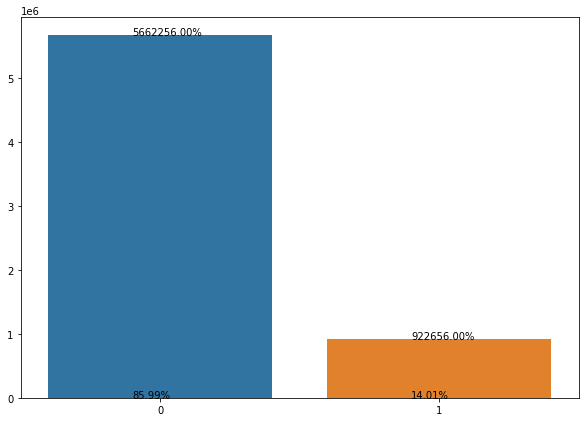

In [16]:
# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(dados_droped, 'trocou_aparelho')

In [17]:
dados_droped['dt_ano_stts'].unique()

array([2021, 2018, 2016, 2020, 2017, 2019, 2015, 2014, 2010, 2011, 2013,
       2012, 2009, 2007, 2006, 2008, 2004, 2005, 2001, 2022, 2003, 1999,
       2002, 2000])

***
### Load Model

In [18]:
# Open saved model, and directly make the prediction with new data
filename = '/kaggle/input/models/model_trocou_aparelho.pk'
with open(filename ,'rb') as f:
    pipeline_ta = pickle.load(f)

In [19]:
X_ta = dados_droped.drop('trocou_aparelho', axis=1)

y_ta = dados_droped['trocou_aparelho']

In [20]:
preds_ta = pipeline_ta.predict(X_ta)

In [21]:
c_val_ta = Counter(y_ta)
c_val_ta

Counter({0: 5662256, 1: 922656})

In [22]:
c_preds_ta = Counter(preds_ta)
c_preds_ta

Counter({0: 5581837, 1: 1003075})

***
## Métricas

AUC: 0.984


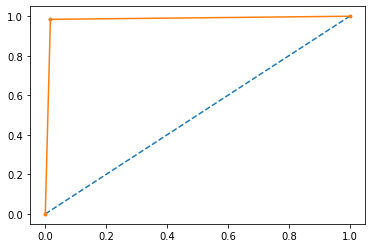

In [23]:
aucur(y_ta, preds_ta)

In [24]:
print(classification_report(y_ta, preds_ta))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99   5662256
           1       0.91      0.98      0.94    922656

    accuracy                           0.98   6584912
   macro avg       0.95      0.98      0.97   6584912
weighted avg       0.98      0.98      0.98   6584912



In [25]:
cm_df_ta = pd.DataFrame(confusion_matrix(y_ta, preds_ta),
                        index = sorted(Counter(y_ta)),
                        columns = sorted(Counter(preds_ta)))
cm_df_ta

,0,1
0,5567359,94897
1,14478,908178


Confusion matrix, without normalization
[[5567359   94897]
 [  14478  908178]]
Normalized confusion matrix
[[0.98324043 0.01675957]
 [0.01569166 0.98430834]]


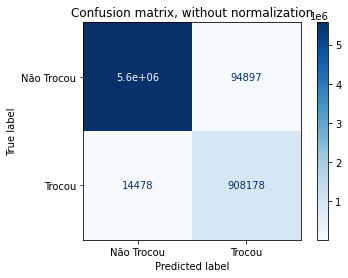

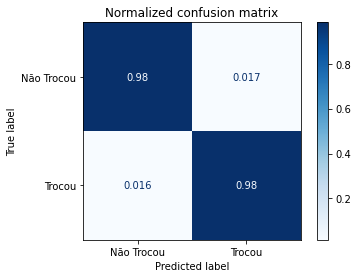

<Figure size 1296x1296 with 0 Axes>

In [26]:
# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        pipeline_ta,
        X_ta,
        y_ta,
        display_labels=['Não Trocou', 'Trocou'],
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
    
plt.figure(figsize=(18, 18))
plt.show()

***
***
***
## Captação dos clientes que foram previstos como Propensos a Fazer uma Compra

Base Original

In [27]:
X_ta['trocou_aparelho'] = y_ta
# X_ta

<Figure size 576x432 with 0 Axes>

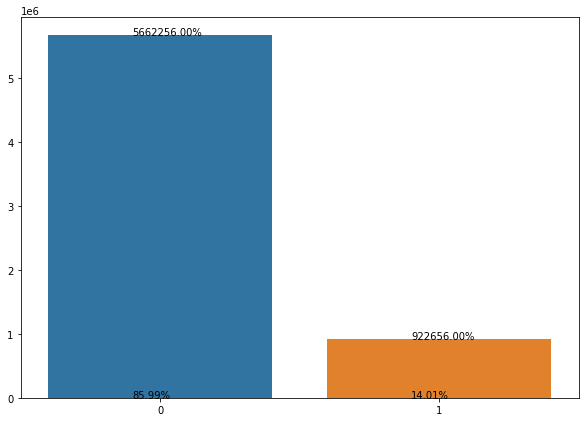

In [28]:
plt.figure(figsize=(8, 6))

# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(X_ta, 'trocou_aparelho')

Base Prevista

In [29]:
X_ta['trocou_aparelho_previsto'] = preds_ta
# X_ta

<Figure size 576x432 with 0 Axes>

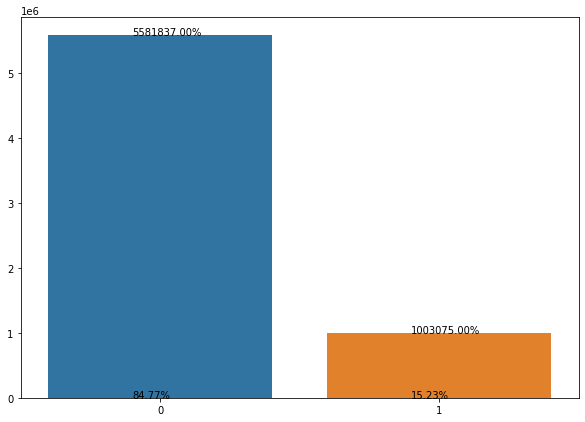

In [30]:
plt.figure(figsize=(8, 6))

plot_feature_freq(X_ta, 'trocou_aparelho_previsto')

In [31]:
X_ta['cpfidentifier'] = dados_droped['cpfidentifier']
# X_ta

In [32]:
X_ta['dt_inicio'] = dados_droped['dt_inicio']
# X_ta

In [33]:
X_ta['dt_fim'] = dados_droped['dt_fim']
X_ta['modelo'] = dados_droped['modelo']
X_ta['subscribermainofferdesc'] = dados_droped['subscribermainofferdesc']
X_ta['assignedchargeamount'] = dados_droped['assignedchargeamount']
X_ta['offertechnology'] = dados_droped['offertechnology']
X_ta['statedesc'] = dados_droped['statedesc']
X_ta['fl_3g'] = dados_droped['fl_3g']
X_ta['fl_4g'] = dados_droped['fl_4g']
# X_ta['fl_5g'] = dados_droped['fl_5g']
X_ta['idade'] = dados_droped['idade']
X_ta['avg_msisdn'] = dados_droped['avg_msisdn']
X_ta['avg_cpf'] = dados_droped['avg_cpf']

X_ta

,msisdn,imsi,tac,dt_inicio,dt_fim,aging_aparelho,cat_aparelho,fabricante,modelo,imei,...,subscribermainofferdesc,assignedchargeamount,fl_3g,fl_4g,dt_ano_stts,idade,avg_msisdn,avg_cpf,trocou_aparelho,trocou_aparelho_previsto
0,5537998231861,724233765873941,35421469,2021-08-09,NaN,17,1,"Motorola Mobility LLC, a Lenovo Company",MOTO E(6)S,354214691487230,...,VIVO CONTROLE 4GB,41.93,0,1,2021,68,0.0,0.0,0,0
1,5551997225363,724065191492347,35223467,2021-10-24,NaN,14,1,"Motorola Mobility LLC, a Lenovo Company",MOTO G(9) PLAY,352234675188010,...,VIVO CTRL DIGITAL-9GB_,62.40,0,1,2021,39,0.0,0.0,0,0
2,5531996330364,724233406091372,35450612,2021-10-01,NaN,15,1,APPLE,IPHONE 12 PRO MAX (A2342),354506127548040,...,CONTROLE MÚSICA 10GB,69.99,0,0,2021,48,0.0,0.0,0,0
3,5554996866600,724065010907570,35456077,2021-12-08,NaN,13,1,"Motorola Mobility LLC, a Lenovo Company",MOTO E(6)I,354560771589770,...,VIVO CONTROLE 9GB I,56.49,0,1,2021,39,0.0,0.0,0,0
4,5596991621965,724119604007824,35634309,2021-10-04,NaN,15,1,SAMSUNG,GALAXY J5 PRIME DUOS (SM-G570M DS),356343098994940,...,VIVO CONTROLE 7GB_ANUAL_,56.99,0,1,2018,42,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6584907,5561996499134,724066490750265,35352472,2021-10-24,NaN,14,1,"Motorola Mobility LLC, a Lenovo Company",GUAM20,353524723239350,...,VIVO CONTROLE 9GB I,60.30,0,1,2020,45,0.0,0.0,0,0
6584908,5522999321919,724112006729288,35248178,2021-12-20,NaN,12,1,"Motorola Mobility LLC, a Lenovo Company",MALTA20,352481786996460,...,VIVO CONTROLE 6GB III,45.99,0,1,2020,54,0.0,0.0,0,0
6584909,5568999488206,724066613074605,35292909,2021-12-16,NaN,12,1,SAMSUNG,GALAXY GRAND PRIME DUOS (SM-G532MT),352929092207380,...,VIVO CONTROLE 5GB IV,36.99,0,1,2017,37,0.0,0.0,0,0
6584910,5555999988485,724065010898645,86212205,2021-10-15,NaN,14,1,XIAOMI,REDMI NOTE 9 (M2003J15SS),862122050876850,...,VIVO CONTROLE 7GB_,52.88,0,1,2020,43,0.0,0.0,0,0


In [63]:
val_acc_ta = accuracy_score(y_ta, preds_ta)
print('Validation Acuracy:', val_acc_ta)

Validation Acuracy: 0.9833900589711753


***
***
***
## Separando as bases para outro modelo

In [35]:
base_to_pred_month = X_ta[X_ta['trocou_aparelho_previsto'] == 1].reset_index(drop=True)
base_to_pred_month

,msisdn,imsi,tac,dt_inicio,dt_fim,aging_aparelho,cat_aparelho,fabricante,modelo,imei,...,subscribermainofferdesc,assignedchargeamount,fl_3g,fl_4g,dt_ano_stts,idade,avg_msisdn,avg_cpf,trocou_aparelho,trocou_aparelho_previsto
0,5588988039599,724118596208177,35946008,2021-05-22,2022-08-06,14,1,APPLE,IPHONE 7 (A1660),359460083674180,...,VIVO CONTROLE 7GB_,56.66,0,1,2017,39,14.0,14.0,1,1
1,5598984843818,724119893014054,35301109,2021-07-11,2022-09-15,14,1,APPLE,IPHONE 8 PLUS (A1864),353011090395470,...,VIVO CONTROLE 11GB - MENSAL,0.00,0,1,2017,39,14.0,14.0,1,1
2,5543991172181,724064190886669,35923309,2021-08-23,2022-09-10,12,1,SAMSUNG,SM-J810M DS,359233092097610,...,VIVO CONTROLE 6GB III,50.99,0,1,2018,44,12.0,12.0,1,1
3,5551999774680,724065191700977,35616011,2021-04-14,2022-08-20,16,1,Samsung Korea,GALAXY A31,356160114319960,...,VIVO CONTROLE 9GB I,61.49,0,1,2020,43,16.0,16.0,1,1
4,5565996867917,724066613532716,86830805,2021-07-06,2022-08-04,12,1,XIAOMI,REDMI 9A (M2006C3LG),868308057222690,...,VIVO CONTROLE 11GB PLN,56.99,0,1,2020,67,12.0,12.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003070,5527997164405,724113002524393,35687011,2021-10-20,2022-11-14,12,1,APPLE,IPHONE 11 (A2111),356870110599300,...,VIVO CONTROLE 9GB I,61.49,0,1,2020,66,12.0,12.0,1,1
1003071,5551996583605,724065010778518,35715510,2021-02-12,2022-07-31,17,1,LG Electronics Inc.,LM-X210BMW,357155106284230,...,VIVO CTRL DIGITAL-11GB ILIM_,67.03,0,1,2019,43,17.0,17.0,1,1
1003072,5527998979742,724112706384504,35411310,2021-02-17,2022-07-26,17,1,Multilaser Industrial S.A.,VITA 3G,354113101160480,...,VIVO CONTROLE 4GB II - MENSAL,37.31,0,1,2018,54,17.0,17.0,1,1
1003073,5554996750264,724065191279991,35556211,2021-04-05,2022-08-26,16,1,MOTOROLA,FIJI (XT2053-2),355562113384250,...,VIVO CONTROLE 8GB II PLN,50.59,0,1,2020,39,16.0,16.0,1,1


***
***
***
## Definição do Target aging_aparelho

In [36]:
# define target
y = base_to_pred_month['aging_aparelho']

In [37]:
# contagem de aging
from collections import Counter

c = Counter(y)
c

Counter({14: 150271,
         12: 182635,
         16: 128731,
         13: 163261,
         15: 136197,
         18: 119523,
         17: 122457})

<Figure size 1440x432 with 0 Axes>

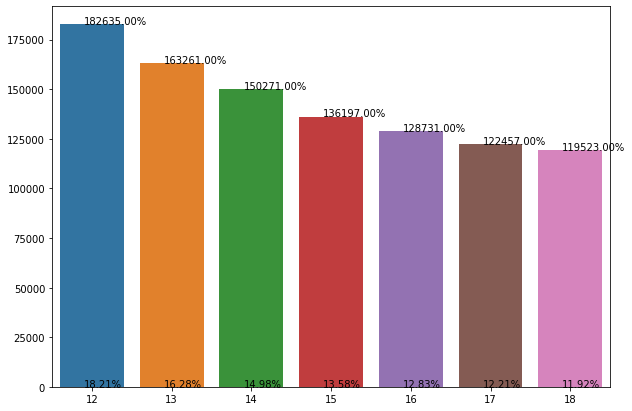

In [38]:
plt.figure(figsize=(20, 6))

# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq_mes(base_to_pred_month, 'aging_aparelho')

***
### Load Model

In [39]:
# Open saved model, and directly make the prediction with new data
filename_ag = '/kaggle/input/models/model_aging.pk'
with open(filename_ag ,'rb') as f:
    pipeline = pickle.load(f)

In [40]:
X = base_to_pred_month.drop('aging_aparelho', axis=1)

y = base_to_pred_month['aging_aparelho']

In [41]:
preds = pipeline.predict(X)

In [42]:
c_val = Counter(y)
c_val

Counter({14: 150271,
         12: 182635,
         16: 128731,
         13: 163261,
         15: 136197,
         18: 119523,
         17: 122457})

In [43]:
c_preds = Counter(preds)
c_preds

Counter({14: 150784,
         12: 167385,
         16: 136510,
         15: 139167,
         18: 126879,
         17: 127731,
         13: 154619})

***
## Métricas

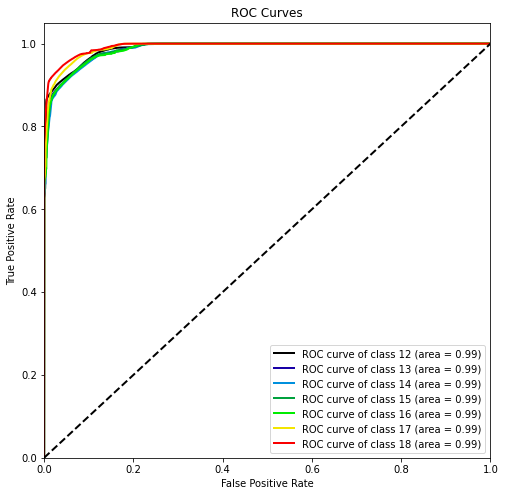

In [44]:
y_probas = pipeline.predict_proba(X)
plot_roc(y, y_probas, plot_micro = False, plot_macro = False, figsize = (8, 8))
plt.show()

In [45]:
print(classification_report(y, preds))

              precision    recall  f1-score   support

          12       0.95      0.87      0.91    182635
          13       0.91      0.86      0.88    163261
          14       0.87      0.87      0.87    150271
          15       0.86      0.87      0.86    136197
          16       0.83      0.88      0.86    128731
          17       0.85      0.89      0.87    122457
          18       0.87      0.92      0.89    119523

    accuracy                           0.88   1003075
   macro avg       0.88      0.88      0.88   1003075
weighted avg       0.88      0.88      0.88   1003075



In [46]:
cm_df = pd.DataFrame(confusion_matrix(y, preds),
                     index = sorted(Counter(y)),
                     columns = sorted(Counter(preds)))
cm_df

,12,13,14,15,16,17,18
12,159334,10006,4587,2973,1820,1971,1944
13,3131,140248,9070,5516,1747,1860,1689
14,825,1554,130767,6244,6889,2633,1359
15,656,765,2286,119051,7438,4553,1448
16,671,691,2523,2014,113707,5814,3311
17,594,652,731,2463,2300,108490,7227
18,2174,703,820,906,2609,2410,109901


## Plot non-normalized confusion matrix

In [47]:
y.unique()

array([14, 12, 16, 13, 15, 18, 17])

Confusion matrix, without normalization
[[159334  10006   4587   2973   1820   1971   1944]
 [  3131 140248   9070   5516   1747   1860   1689]
 [   825   1554 130767   6244   6889   2633   1359]
 [   656    765   2286 119051   7438   4553   1448]
 [   671    691   2523   2014 113707   5814   3311]
 [   594    652    731   2463   2300 108490   7227]
 [  2174    703    820    906   2609   2410 109901]]
Normalized confusion matrix
[[0.87241766 0.05478687 0.02511567 0.01627837 0.00996523 0.01079202
  0.01064418]
 [0.01917788 0.85904166 0.05555522 0.03378639 0.01070066 0.0113928
  0.0103454 ]
 [0.00549008 0.01034132 0.87020782 0.0415516  0.04584384 0.01752168
  0.00904366]
 [0.00481655 0.00561686 0.01678451 0.87410883 0.05461207 0.03342952
  0.01063166]
 [0.00521242 0.00536778 0.01959901 0.01564503 0.88329151 0.04516395
  0.0257203 ]
 [0.00485068 0.00532432 0.00596944 0.02011318 0.0187821  0.88594364
  0.05901663]
 [0.01818897 0.00588171 0.0068606  0.00758013 0.02182843 0.02016348
  0.9194

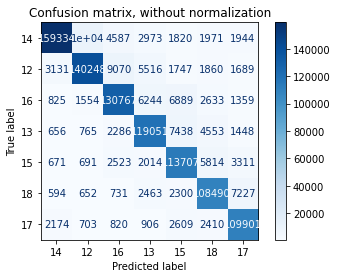

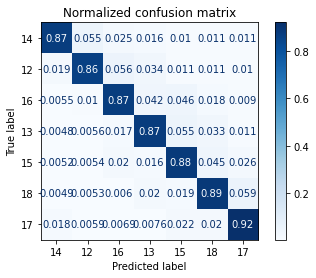

<Figure size 1800x1800 with 0 Axes>

In [48]:
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        pipeline,
        X,
        y,
        display_labels=y.unique(),
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
    
plt.figure(figsize=(25, 25))
plt.show()

***
## Mesclando resultados com tabela

### Com a base de validação

In [49]:
X['aging_aparelho'] = y
# X

In [50]:
X['aging_aparelho_previsto'] = preds
# X

In [51]:
X['cpfidentifier'] = base_to_pred_month['cpfidentifier']
# X

In [52]:
X['dt_inicio'] = base_to_pred_month['dt_inicio']
# X

In [53]:
X['dt_fim'] = base_to_pred_month['dt_fim']
# X

In [54]:
val_acc = accuracy_score(y, preds)
print('Validation Acuracy:', val_acc)

Validation Acuracy: 0.8787957032126212


***
## Calculando data prevista

In [62]:
X['dt_fim_previsto'] = ((pd.to_datetime(X['dt_inicio']).dt.to_period('M')) + X['aging_aparelho_previsto'])
X

,msisdn,imsi,tac,dt_inicio,dt_fim,cat_aparelho,fabricante,modelo,imei,ranking,...,fl_4g,dt_ano_stts,idade,avg_msisdn,avg_cpf,trocou_aparelho,trocou_aparelho_previsto,aging_aparelho,aging_aparelho_previsto,dt_fim_previsto
0,5588988039599,724118596208177,35946008,2021-05-22,2022-08-06,1,APPLE,IPHONE 7 (A1660),359460083674180,1,...,1,2017,39,14.0,14.0,1,1,14,14,2022-07
1,5598984843818,724119893014054,35301109,2021-07-11,2022-09-15,1,APPLE,IPHONE 8 PLUS (A1864),353011090395470,1,...,1,2017,39,14.0,14.0,1,1,14,14,2022-09
2,5543991172181,724064190886669,35923309,2021-08-23,2022-09-10,1,SAMSUNG,SM-J810M DS,359233092097610,1,...,1,2018,44,12.0,12.0,1,1,12,12,2022-08
3,5551999774680,724065191700977,35616011,2021-04-14,2022-08-20,1,Samsung Korea,GALAXY A31,356160114319960,1,...,1,2020,43,16.0,16.0,1,1,16,16,2022-08
4,5565996867917,724066613532716,86830805,2021-07-06,2022-08-04,1,XIAOMI,REDMI 9A (M2006C3LG),868308057222690,1,...,1,2020,67,12.0,12.0,1,1,12,12,2022-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003070,5527997164405,724113002524393,35687011,2021-10-20,2022-11-14,1,APPLE,IPHONE 11 (A2111),356870110599300,1,...,1,2020,66,12.0,12.0,1,1,12,12,2022-10
1003071,5551996583605,724065010778518,35715510,2021-02-12,2022-07-31,1,LG Electronics Inc.,LM-X210BMW,357155106284230,1,...,1,2019,43,17.0,17.0,1,1,17,17,2022-07
1003072,5527998979742,724112706384504,35411310,2021-02-17,2022-07-26,1,Multilaser Industrial S.A.,VITA 3G,354113101160480,1,...,1,2018,54,17.0,17.0,1,1,17,17,2022-07
1003073,5554996750264,724065191279991,35556211,2021-04-05,2022-08-26,1,MOTOROLA,FIJI (XT2053-2),355562113384250,1,...,1,2020,39,16.0,16.0,1,1,16,16,2022-08


In [59]:
X.to_excel(r'ta_predicted.xlsx')

In [61]:
X.to_csv(r'ta_predicted.csv')